# Experiments

In [2]:
# Make sure that you have build the search module 
import subprocess
import json
import gzip
import sys
import os
import matplotlib
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
from statistics import mean
from matplotlib import colormaps as cm
from matplotlib import transforms

sys.path.append(os.path.abspath("../clean_generation"))
import generate
from parseRePEAT import *

## Data generation

In [3]:
# Write results to a file specified for all different scenarios/layouts
with open("results_enkhuizen+heerlen.csv", "w") as f:
    scenarios = {
        "enkhuizen": {
            "small": "../data/enkhuizen/scenario_small.json", 
            "medium": "../data/enkhuizen/scenario_reallife_enkhuizen.json",
            "large": "../data/enkhuizen/scenario_n25_t8_w1000_s5683269.json", 
        },
        "heerlen": {
            "small": "../data/heerlen/scenario_n6_t2_w1000_s1786596167.json",
            "medium": "../data/heerlen/scenario_n13_t3_w1000_s1786596167.json",
            "large": "../data/heerlen/scenario_n25_t5_w1000_s1786596167.json",
            "extralarge": "../data/heerlen/scenario_n50_t10_w1000_s1786596167.json",
        }
    }
    layouts = {"enkhuizen": "../data/enkhuizen/location_enkhuizen.json", "heerlen": "../data/heerlen/location_heerlen.json"}
    f.write("Layout,Scenario,Agent,Start,Goal,StartTime,ScenarioTime,NodeIntervals,EdgeIntervals,GenTime,SearchTime,LookupTime,Path,PathLength,PathUsed,PathOccurrence,PathTraversalTime,PathSafeIntervals,SippSearch,SippLookup\n")
    for layout in scenarios:
        for scen in scenarios[layout]:
            scenario_data = json.load(open(scenarios[layout][scen]))
            train_types = {x["name"]: x for x in scenario_data["types"]}
            # Iteratively assign one of the trains to be the agent
            for agent in scenario_data['trains']:
                # Get the global end time of scenario
                scenario_end_time = 0
                for i in range(len(agent["movements"])):
                    move = agent["movements"][i]
                    if move["endTime"] > scenario_end_time:
                        scenario_end_time = move["endTime"]
                agent_speed = train_types[agent["trainUnitTypes"][0]]["speed"]
                print(f"Computing results for agent {agent['trainNumber']} in scenario {scen} on layout {layout}")
                for move in agent["movements"]:
                    # Generate intervals
                    generation_time = generate.time_safe_intervals_and_write(layouts[layout], scenarios[layout][scen], agent["trainNumber"], agent_speed, "output")
                    safe_interval_output = [str(x).split("'")[1] for x in gzip.open("output").readlines()]

                    # Run SIPP baseline
                    try:
                        proc = subprocess.run(["../atSIPP/build/atsipp", "--start", move["startLocation"], "--goal", move["endLocation"], "--edgegraph", "output", "--search", "sipp", "--startTime", str(move["startTime"]), "--agentSpeed", str(agent_speed), "--walkingSpeed", str(scenario_data["walkingSpeed"])], timeout=300, stdout=subprocess.PIPE, stderr=subprocess.DEVNULL)
                    except subprocess.TimeoutExpired:
                        print(f'Timeout for sipp (300s) expired')
                    sipp_output = str(proc.stdout).split("'")[1].strip("\\n").split("\\n")
                    # SIPP results
                    if int(proc.returncode) == 0:
                        sipp_search_time = [float(x.split(" ")[2]) for x in sipp_output if "Search time" in x][0]
                        # SIPP lookup is instant and set to 1 nanosecond
                        sipp_lookup_time = 1 

                    # Run RePeAT to get multiple plans
                    try:
                        proc = subprocess.run(["../atSIPP/build/atsipp", "--start", move["startLocation"], "--goal", move["endLocation"], "--edgegraph", "output", "--search", "repeat", "--startTime", str(move["startTime"]), "--agentSpeed", str(agent_speed), "--walkingSpeed", str(scenario_data["walkingSpeed"])], timeout=300, stdout=subprocess.PIPE, stderr=subprocess.DEVNULL)
                    except subprocess.TimeoutExpired:
                        print(f'Timeout for repeat (300s) expired')                            
                    repeat_output = str(proc.stdout).split("'")[1].strip("\\n").split("\\n")
                    try: 
                        all_lookups = [(int(x.split(" ")[1].strip(")").split("=")[1]), float(x.split(" ")[4])) for x in repeat_output if "Lookup time" in x]
                        # Divide by number of lookups provided: Total (n=<x>) Lookup time: <y> nanoseconds
                        lookup_time = mean([y / x for x, y in all_lookups])
                    except: lookup_time = np.nan

                    # If the run was successful
                    if int(proc.returncode) == 0:
                        search_time = [float(x.split(" ")[2]) for x in repeat_output if "Search time" in x][0]
                        metadata, catf, paths, eatfs = parse_list_of_outputs(repeat_output)
                        total_paths_found = sum([paths[p] for p in paths])
                        for path_name in paths:
                            # The ratio of how often this path was found
                            occurrence = paths[path_name] / total_paths_found
                            path_length = len(path_name.split(";"))
                            path_traversal = eatfs[path_name][0][3] # traversal is same no matter the start time
                            # Get the different safe intervals (start, end) for traversing the current path
                            path_eatfs = ";".join([f"<{float(e[1])}-{float(e[2])}>" for e in eatfs[path_name]])
                            f.write(f"{layout},{scen},{str(agent['trainNumber'])},{move['startLocation']},{move['endLocation']},{move['startTime']},<{0}-{scenario_end_time}>,{safe_interval_output[0][0:-2].split(' ')[-1]},{sum([1 for x in safe_interval_output if len(x.split(' ')) == 6])},{generation_time},{'{0:.9f}'.format(search_time*10**-9)},{'{0:.9f}'.format(lookup_time*10**-9)},[{path_name}],{path_length},{paths[path_name]},{occurrence},{path_traversal},{path_eatfs},{'{0:.9f}'.format(sipp_search_time*10**-9)},{'{0:.9f}'.format(sipp_lookup_time*10**-9)}\n")
                    else:
                        f.write(f"{layout},{scen},{str(agent['trainNumber'])},{move['startLocation']},{move['endLocation']},{move['startTime']},<{0}-{scenario_end_time}>,{safe_interval_output[0][0:-2].split(' ')[-1]},{sum([1 for x in safe_interval_output if len(x.split(' ')) == 6])},{generation_time},{np.nan},{'{0:.9f}'.format(lookup_time*10**-9)},[],0,{np.nan},{np.nan},0,[()],0,0\n")


Computing results for agent 1 in scenario small on layout enkhuizen
Computing results for agent 2 in scenario small on layout enkhuizen
Computing results for agent 3 in scenario small on layout enkhuizen
Computing results for agent 4 in scenario small on layout enkhuizen
Computing results for agent 5 in scenario small on layout enkhuizen
Computing results for agent 6 in scenario small on layout enkhuizen
Computing results for agent 3317 in scenario medium on layout enkhuizen
Computing results for agent 2919 in scenario medium on layout enkhuizen
Computing results for agent 2921 in scenario medium on layout enkhuizen
Computing results for agent 3923 in scenario medium on layout enkhuizen
Computing results for agent 3925 in scenario medium on layout enkhuizen
Computing results for agent 4527 in scenario medium on layout enkhuizen
Computing results for agent 3927 in scenario medium on layout enkhuizen
Computing results for agent 3929 in scenario medium on layout enkhuizen
Computing result

In [ ]:
df = pd.read_csv('results_enkhuizen+heerlen.csv')
# To show what the data looks like
df.head(20)

In [ ]:
# Plot runtime both methods for all layouts and scenarios - sorted per scenario and layout
nan = np.nan
newdf = df.query('PathUsed != @nan').groupby(['Scenario', 'Layout'])

means = {
    "rSIPP": {
        "Generation time": np.array(newdf['GenTime'].mean().sort_values(ascending=True).unstack(level=0).sort_index(axis=1, ascending=False)),
        "Search time": np.array(newdf['SippSearch'].mean().sort_values(ascending=True).unstack(level=0).sort_index(axis=1, ascending=False)),
    },
    "@MAEDeR": {
        "Generation time": np.array(newdf['GenTime'].mean().sort_values(ascending=True).unstack(level=0).sort_index(axis=1, ascending=False)),
        "Search time": np.array(newdf['SearchTime'].mean().sort_values(ascending=True).unstack(level=0).sort_index(axis=1, ascending=False)),
    }
}
stds = {
    "rSIPP": {
        "Search time": np.array(newdf['SippSearch'].std().sort_values(ascending=True).unstack(level=0).sort_index(axis=1, ascending=False)),
        "Generation time": np.array(newdf['GenTime'].std().sort_values(ascending=True).unstack(level=0).sort_index(axis=1, ascending=False)),
    },
    "@MAEDeR": {
        "Search time": np.array(newdf['SearchTime'].std().sort_values(ascending=True).unstack(level=0).sort_index(axis=1, ascending=False)),
        "Generation time": np.array(newdf['GenTime'].std().sort_values(ascending=True).unstack(level=0).sort_index(axis=1, ascending=False)),
    }
}
labels = {
    "small": "6 trains",
    "medium": "13 trains",
    "large": "25 trains",
    "extralarge": "50 trains"
}
layouts = [
    "Enkhuizen",
    "Heerlen"
]
search = [
    "rSIPP",
    "@MAEDeR"
]
legend = {
    "rSIPP": {
        "Search time": "Search for plan",
        "Generation time": "Recompute SIPP graph",
    },
    "@MAEDeR": {
        "Search time": "Search for plan",
        "Generation time": "Recompute @SIPP graph",        
    }
}
colors = {
    "@MAEDeR": {
        "Generation time": '#e66101',
        "Search time": '#fdb863'
    },
    "rSIPP": {
        "Generation time": "#5e3c99",
        "Search time": '#b2abd2',
    }
}

fig, ax = plt.subplots()

errors = {
    "Generation time": {
        "ecolor": 'black',
        "fmt": 'ks',
        "transform": transforms.Affine2D().translate(-0.03, 0.0) + ax.transData
    },
    "Search time": {
        "ecolor": 'black',
        "fmt": 'ko',
        "transform": transforms.Affine2D().translate(+0.03, 0.0) + ax.transData
    }
}

bar_width = 0.1
legends = {}
for i, l in enumerate(layouts):
    for k, s in enumerate(search):
        bottom = np.zeros(len(labels))
        for name, x in means[s].items():
            positions = i + np.arange(len(labels.values()))*2.5*bar_width + k*bar_width
            p = ax.bar(positions, x[i], label=legend[s][name] + " " + s, bottom=bottom, color=colors[s][name], width=bar_width)
            # e = ax.errorbar(positions, x[i] + bottom, yerr=stds[s][name], fmt=errors[name]['fmt'], ecolor=errors[name]['ecolor'], linestyle="none", transform=errors[name]['transform'])
            if l == "Enkhuizen":
                legends[legend[s][name] + " " + s] = p
            bottom += x[i]

ax.annotate("Enkhuizen hub", xy=(0.4, 0), xytext=(-0.1, -0.033))
ax.annotate("Heerlen hub", xy=(0.4, 0), xytext=(1, -0.033))
ax.annotate("Scenario\nsize", xy=(0, 0), xytext=(-0.6, -0.02), weight='bold')

ax.set_xticks([0.05, 0.3, 0.55, 1.05, 1.3, 1.55, 1.8])
ax.set_xticklabels(list(labels.values())[0:-1] + list(labels.values()), rotation=45, ha='right')
ax.xaxis.set_label_coords(0.6, -0.2)
ax.minorticks_on()
ax.xaxis.set_tick_params(which='minor', bottom=False)

ax.set_ylabel("Time (s)", rotation='horizontal', weight='bold')
ax.yaxis.get_ticklocs(minor=True)
ax.yaxis.set_label_coords(-0.1, 0.95)
ax.set_ylim(0, max(newdf['GenTime'].mean() + newdf['SearchTime'].mean()) * 1.05)
# ax.set_title("Average computation time @MAEDeR vs rSIPP")
ax.legend(legends.values(), legends.keys(), loc=(0, 0.68), ncol=1, frameon=False)

plt.rcParams.update({'font.size': 14})
plt.savefig("results/runtimes_dpi600.png", 
            dpi=600,
            bbox_inches="tight")

## Fig8 - @MAEDeR and rSIPP milestones

In [8]:
# Helper object for legend with subtitles
import matplotlib.text as mtext

class LegendTitle(object):
    def __init__(self, text_props=None):
        self.text_props = text_props or {}
        super(LegendTitle, self).__init__()

    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        title = mtext.Text(x0, y0, orig_handle,  **self.text_props)
        handlebox.add_artist(title)
        return title
    
from matplotlib.ticker import FuncFormatter

# Function to format tick labels
def format_tick(value, tick_number):
    return f'10^{tick_number}'
log_formatter = FuncFormatter(format_tick)

@MAEDeR recompute SIPP graph [0.01433986 0.35242702]
rSIPP recompute SIPP graph [0.01433986 0.35242702]


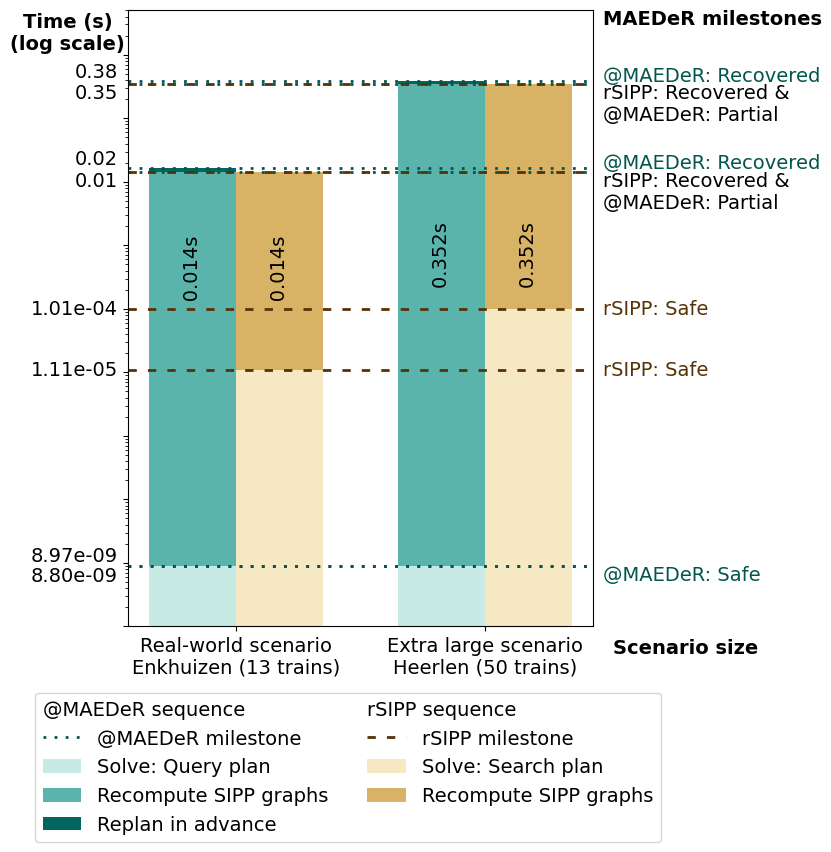

In [21]:
# Creating stack barplot of different milestones with medium enkhuizen and extralarge heerlen scenarios
scenarios = 2
nan = np.nan

newdf = df.query('PathUsed != @nan and (Layout == "enkhuizen" and Scenario == "medium") or (Layout == "heerlen" and Scenario == "extralarge")')
asipp = newdf

sipp = newdf
sipp['Query'] = newdf['SippSearch'] + newdf['SippLookup']
sipp['Recompute'] = newdf['SippSearch'] + newdf['GenTime']

fig = plt.figure(figsize=(3*scenarios, 8))
ax = fig.add_subplot()
bar_width = 0.35
fontsize = 14
# print(df.query('(Layout == "heerlen" and Scenario == "medium")').head(100))


colors = {
    "SIPP": {
        "Bar1": '#f6e8c3',
        "Bar2": '#d8b365',
        "Bar3": "#8c510a",
        "Line": '#573206'
    },
    "@SIPP": {
        "Bar1": "#c7eae5",
        "Bar2": '#5ab4ac',
        "Bar3": '#01665e',
        "Line": '#02554d'
    }
}
errors = {
    "Bar1": {
        "ecolor": 'black',
        "fmt": 'ks',
        "transform": transforms.Affine2D().translate(-0.1, 0.0) + ax.transData
    },
    "Bar2": {
        "ecolor": 'gray',
        "fmt": 'k^',
        "transform": transforms.Affine2D().translate(0, 0.0) + ax.transData
    },
    "Bar3": {
        "ecolor": 'gray',
        "fmt": 'ko',
        "transform": transforms.Affine2D().translate(+0.1, 0.0) + ax.transData
    }
}

## @SIPP

positions_asipp = [0, 1]
positions_sipp = [0+bar_width, 1+bar_width]

plot_first = 1
plot_second = 0

### Lookup time: querying the safe plan
lookups = np.array(asipp.groupby('Scenario')['LookupTime'].mean().sort_index(ascending=False))
asipp_lookup = ax.bar(positions_asipp, lookups, label="Solve: Query plan", bottom=0, color=colors["@SIPP"]["Bar1"], width=bar_width)
asipp_line = ax.axhline(lookups[plot_first], color=colors["@SIPP"]["Line"], xmin=0, xmax=1, linewidth=2, dashes=(1, 3))
ax.annotate('{:.2e}'.format(lookups[plot_first]), xy=(0, lookups[plot_first]), xytext=(-0.3, lookups[plot_first]), va='bottom', ha='right')
ax.annotate("@MAEDeR: Safe", xy=(1, lookups[plot_first]), xytext=(1.65, lookups[plot_first]), va='top', color=colors["@SIPP"]["Line"])
if plot_second >= 0:
    ax.axhline(lookups[plot_second], color=colors["@SIPP"]["Line"], xmin=0, xmax=1, linewidth=2, dashes=(1, 3))
    ax.annotate('{:.2e}'.format(lookups[plot_second]), xy=(0, lookups[plot_second]), xytext=(-0.3, lookups[plot_second]), va='top', ha='right')

### Generation time: recomputing SIPP graphs other agents
graphs = np.array(asipp.groupby(['Scenario', 'Agent']).sum('GenTime').groupby('Scenario')['GenTime'].mean().sort_index(ascending=False))
asipp_graphs = ax.bar(positions_asipp, graphs, label="Recompute SIPP graphs", bottom=lookups, color=colors["@SIPP"]["Bar2"], width=bar_width)
height = lookups + graphs
ax.axhline(height[plot_first], color=colors["@SIPP"]["Line"], xmin=0, xmax=1, linewidth=2, dashes=(1, 3))
ax.annotate('{:.2f}'.format(height[plot_first]), xy=(0, height[plot_first]), xytext=(-0.3, height[plot_first]), va='top', ha='right')
ax.annotate("rSIPP: Recovered &\n@MAEDeR: Partial", xy=(1, height[plot_first]), xytext=(1.65, height[plot_first]), va='top')
if plot_second >= 0:
    ax.axhline(height[plot_second], color=colors["@SIPP"]["Line"], xmin=0, xmax=1, linewidth=2, dashes=(1, 3))
    ax.annotate('{:.2f}'.format(height[plot_second]), xy=(0, height[plot_second]), xytext=(-0.3, height[plot_second]), va='top', ha='right')
    ax.annotate("rSIPP: Recovered &\n@MAEDeR: Partial", xy=(1, height[plot_second]), xytext=(1.65, height[plot_second]),  va='top')

### Search time: recomputing any-start-time plans for other agents
others = np.array(asipp.groupby(['Scenario', 'Agent']).sum('SearchTime').groupby('Scenario')['SearchTime'].mean().sort_index(ascending=False))
height = lookups + graphs + others
asipp_recompute = ax.bar(positions_asipp, others, label="Replan in advance", bottom=lookups + graphs, color=colors["@SIPP"]["Bar3"], width=bar_width)
ax.axhline(height[plot_first], color=colors["@SIPP"]["Line"], xmin=0, xmax=1, linewidth=2, dashes=(1, 3))
ax.annotate('{:.2f}'.format(height[plot_first]), xy=(0, height[plot_first]), xytext=(-0.3, height[plot_first]), va='bottom', ha='right')
ax.annotate("@MAEDeR: Recovered", xy=(1, height[plot_first]), xytext=(1.65, height[plot_first]), va='baseline', color=colors["@SIPP"]["Line"])
if plot_second >= 0:
    ax.axhline(height[plot_second], color=colors["@SIPP"]["Line"], xmin=0, xmax=1, linewidth=2, dashes=(1, 3))
    ax.annotate('{:.2f}'.format(height[plot_second]), xy=(0, height[plot_second]), xytext=(-0.3, height[plot_second]), va='bottom', ha='right')
    ax.annotate("@MAEDeR: Recovered", xy=(1, height[plot_second]), xytext=(1.65, height[plot_second]), va='baseline', color=colors["@SIPP"]["Line"])

# SIPP
### Search time: querying the plan: cpp search time + lookup time
query = np.array(sipp.groupby('Scenario')['Query'].mean().sort_index(ascending=False))
sipp_query = ax.bar(positions_sipp, query, label="Solve: Search plan", bottom=0, color=colors["SIPP"]["Bar1"], width=bar_width)
sipp_line = ax.axhline(query[plot_first], color=colors["SIPP"]["Line"], xmin=0, xmax=1, linewidth=2, dashes=(3, 4))
ax.annotate('{:.2e}'.format(query[plot_first]), xy=(0, query[plot_first]), xytext=(-0.3, query[plot_first]), va='center', ha='right')
ax.annotate("rSIPP: Safe", xy=(1, query[plot_first]), xytext=(1.65, query[plot_first]), va='center', color=colors["SIPP"]["Line"])
if plot_second >= 0:
    ax.axhline(query[plot_second], color=colors["SIPP"]["Line"], xmin=0, xmax=1, linewidth=2, dashes=(3, 4))
    ax.annotate('{:.2e}'.format(query[plot_second]), xy=(0, query[plot_second]), xytext=(-0.3, query[plot_second]), va='center', ha='right')
    ax.annotate("rSIPP: Safe", xy=(1, query[plot_second]), xytext=(1.65, query[plot_second]), va='center', color=colors["SIPP"]["Line"])

### Recompute time: summing generation + search time for all other agents
recomputes = np.array(sipp.groupby(['Scenario', 'Agent']).sum('GenTime').groupby('Scenario')['GenTime'].mean().sort_index(ascending=False))
sipp_recompute = ax.bar(positions_sipp, recomputes, label="Recompute SIPP graphs", bottom=query, color=colors["SIPP"]["Bar2"], width=bar_width)
ax.axhline(recomputes[plot_first], color=colors["SIPP"]["Line"], xmin=0, xmax=1, linewidth=2, dashes=(3, 4))
# Text in rSIPP recompute box, to match the @MAEDeR Recompute
# Make sure this is positioned without lines crossing it
ax.annotate('    {:.3f}s'.format(recomputes[plot_first]), xy=(0.1, query[plot_first]), xytext=(positions_sipp[plot_first], query[plot_first]), ha='center', rotation='vertical')
# The MAEDeR value - position at same height
ax.annotate('    {:.3f}s'.format(graphs[plot_first]), xy=(0.1, query[plot_first]), xytext=(positions_asipp[plot_first], query[plot_first]), ha='center', rotation='vertical')
if plot_second >= 0:
    ax.axhline(recomputes[plot_second], color=colors["SIPP"]["Line"], xmin=0, xmax=1, linewidth=2, dashes=(3, 4))
    # Text in rSIPP recompute box, to match the @MAEDeR Recompute
    # Make sure this is positioned without lines crossing it
    ax.annotate('           {:.3f}s'.format(recomputes[plot_second]), xy=(0.1, query[plot_second]), xytext=(positions_sipp[plot_second], query[plot_second]), rotation='vertical', ha='center', va='bottom')
    # The MAEDeR value - position at same height
    ax.annotate('           {:.3f}s'.format(graphs[plot_second]), xy=(0.1, query[plot_second]), xytext=(positions_asipp[plot_second], query[plot_second]), rotation='vertical', va='bottom', ha='center')


## Recompute SIPP graph time for both
print(f"@MAEDeR recompute SIPP graph", graphs)
print(f"rSIPP recompute SIPP graph", recomputes)

ax.annotate("MAEDeR milestones", xy=(1.6, 1.6), xytext=(1.65,3), weight='bold')
ax.set_xticks(np.arange(scenarios) + (len(layouts)) * bar_width / 4)
ax.set_xticklabels(["Real-world scenario\nEnkhuizen (13 trains)", "Extra large scenario\nHeerlen (50 trains)"])
ax.set_xlabel("Scenario size", weight='bold')
ax.set_yticks([])
ax.set_yscale("log")
min_exponent = np.floor(np.log10(np.abs(min(newdf.query('LookupTime > 0')['LookupTime']))))
ax.set_ylim(10**(min_exponent), 5)
ax.set_ylabel("Time (s)\n(log scale)", rotation='horizontal', weight='bold')
ax.yaxis.set_major_formatter(matplotlib.ticker.NullFormatter())
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
# ax.set_title("Comparing @MAEDeR with rSIPP", loc='center', fontsize=22, fontweight='bold')
ax.legend(["@MAEDeR sequence", asipp_line, asipp_lookup, asipp_graphs, asipp_recompute, "rSIPP sequence", sipp_line, sipp_query, sipp_recompute],
          ["", "@MAEDeR milestone", asipp_lookup.get_label(), asipp_graphs.get_label(), asipp_recompute.get_label(), "", "rSIPP milestone", sipp_query.get_label(), sipp_recompute.get_label()],
          handler_map={str: LegendTitle({'fontsize': fontsize})},
          loc=(-0.2,-0.35),
          ncol=2)
ax.xaxis.set_label_coords(1.2, -0.02)
ax.yaxis.set_label_coords(-0.13, 0.93)

plt.rcParams.update({'font.size': fontsize})
plt.savefig("results/sipp_vs_asipp_dpi600.png",
            bbox_inches="tight",
            dpi=600,
            format='png')

## Create Fig9 - runtime per layout and scenario: safe + unsafe intervals

# Statistics on paths used

In [6]:
df = pd.read_csv("results_enkhuizen+heerlen.csv")
nan = np.nan
newdf = df.copy()
pathdf = df.query('PathUsed != @nan').groupby(['Scenario', 'Layout', 'Start', 'Goal', 'Agent'])
newdf['MinLengthPath'] = pathdf[['PathLength']].transform(min)
newdf.head()

path_occurence_average = newdf.query('PathUsed != @nan and PathLength == MinLengthPath')['PathOccurrence'].mean()
print(f"The shortest path was used in {path_occurence_average * 100}% of the cases")

# Prints a row for each path, but only in cases where more than one path was found
pathdf = newdf.query('PathUsed != @nan and PathOccurrence < 1').groupby(['Scenario', 'Layout', 'Start', 'Goal', 'Agent'])[['Scenario', 'Layout', 'Agent', 'Start', 'Goal', 'PathLength', 'PathUsed', 'PathOccurrence', 'MinLengthPath']]
pathdf.head()


The shortest path was used in 80.06422536247743% of the cases


,Scenario,Layout,Agent,Start,Goal,PathLength,PathUsed,PathOccurrence,MinLengthPath
3,small,enkhuizen,2,t-402A,t-EHA,5,6.0,0.750000,5
4,small,enkhuizen,2,t-402A,t-EHA,15,2.0,0.250000,5
6,small,enkhuizen,3,t-401A,t-404B,7,2.0,0.666667,7
7,small,enkhuizen,3,t-401A,t-404B,15,1.0,0.333333,7
8,small,enkhuizen,4,t-403A,t-401A,11,8.0,0.800000,11
...,...,...,...,...,...,...,...,...,...
419,extralarge,heerlen,45,t-217A,t-40B,46,3.0,0.136364,34
420,extralarge,heerlen,45,t-217A,t-40B,34,2.0,0.090909,34
421,extralarge,heerlen,45,t-217A,t-40B,46,2.0,0.090909,34
427,extralarge,heerlen,48,t-202B,t-40B,25,5.0,0.714286,25
